In [57]:
import dask.dataframe as dd
from IPython.display import display
import numpy as np
import pickle
import matplotlib.pyplot as plt
import ast
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.ndimage import binary_dilation
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from joblib import Parallel, delayed
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, LinearSegmentedColormap
def log_func(x, a, b, c):
    return a * np.log(x + b) + c
parquet_file_path = 'SimulationResults/UltimateAnalysis/PhasePortraitResourcesBacteriaPhage/PhasePortraitResourcesBacteriaPhage.parquet'
pickle_file_path = 'SimulationResults/UltimateAnalysis/PhasePortraitResourcesBacteriaPhage/PhasePortraitResourcesBacteriaPhage.pickle'

In [58]:
def analyze_matrix(pickle_data):
    matrix = np.zeros((len(pickle_data['param_values_list_combination'][0]), len(pickle_data['param_values_list_combination'][1]), len(pickle_data['param_values_list_combination'][2])))
    matrix2 = np.zeros((len(pickle_data['param_values_list_combination'][0]), len(pickle_data['param_values_list_combination'][1]), len(pickle_data['param_values_list_combination'][2])))
    def process_resource(i, resource_value):
        print("querying on resource=", resource_value)
        ddf = dd.read_parquet(
            parquet_file_path,
            engine='pyarrow',
            include_partition_columns=True,
            gather_statistics=True,
            dtype_backend='pyarrow',
            filters=[("Resources", "==", str(resource_value))]
        )
        ddf = ddf.rename(columns={'Uninfected Bacteria': 'Uninfected_Bacteria'})
        local_matrix = np.zeros((len(pickle_data['param_values_list_combination'][1]), len(pickle_data['param_values_list_combination'][2])))
        local_matrix2 = np.zeros((len(pickle_data['param_values_list_combination'][1]), len(pickle_data['param_values_list_combination'][2])))
        for j, bacteria_value in enumerate(pickle_data['param_values_list_combination'][1]):
            for k, phage_value in enumerate(pickle_data['param_values_list_combination'][2]):
                simulation_results = ddf.query(f"Phages == {phage_value} and Uninfected_Bacteria == {bacteria_value}").compute()
                y_values = np.array(ast.literal_eval(simulation_results['y_values'].iloc[0]))[-1, :]
                if np.any(y_values > phage_value * 2):
                    local_matrix[j, k] = np.max(y_values)
                    local_matrix2[j, k] = 1
        return local_matrix, local_matrix2

    results = Parallel(n_jobs=-1)(
        delayed(process_resource)(i, resource_value)
        for i, resource_value in enumerate(pickle_data['param_values_list_combination'][0])
    )

    for i, (col, col2) in enumerate(results):
        matrix[i, :, :] = col
        matrix2[i, :, :] = col2
    return matrix, matrix2

In [67]:
def create_plot(x_dim, y_dim, z_dim, matrix, pickle_data, save_fig=None):
    fig = plt.figure(figsize=(10, 6))
    voxels = np.zeros((x_dim, y_dim, z_dim), dtype=bool)
    print(x_dim, y_dim, z_dim)
    for i in range(x_dim):
        for j in range(y_dim):
            for k in range(z_dim):
                if matrix[i, j, k] > 0:
                    voxels[i, j, k] = matrix[i, j, k]
    # Normalize matrix values for color mapping (0 = white, max = red)
    norm = Normalize(vmin=matrix.min(), vmax=matrix.max())
    norm_matrix = norm(matrix)
    colors = np.ones(voxels.shape + (4,), dtype=float)
    colors[..., 0] = 1  # Red channel
    colors[..., 1] =  1 - norm_matrix  # Green channel decreases with value
    colors[..., 2] = 1 - norm_matrix  # Blue channel decreases with value
    colors[..., 3] = voxels.astype(float)  # Alpha channel: only show where voxels is True
    fig = plt.figure(figsize=(18, 18))
    views = [
    (30, -60), 
    (30, -120), 
    (30, 60), 
    (30, 120), 
    (-30, -60),
    (-30, -120), 
    (-30, 60),
    (-30, 120), 
]
    xtick_indices = np.arange(0, x_dim, 5)
    xtick_labels = [f"{v:.3f}" for v in np.array(pickle_data['param_values_list_combination'][0])[xtick_indices]]
    ytick_indices = np.arange(0, y_dim, 5)
    ytick_labels = [f"{v:.3f}" for v in np.array(pickle_data['param_values_list_combination'][1])[ytick_indices]]
    ztick_indices = np.arange(0, z_dim, 5)
    ztick_labels = [f"{v:.3f}" for v in np.array(pickle_data['param_values_list_combination'][2])[ztick_indices]]

    for idx, (elev, azim) in enumerate(views):
        ax = fig.add_subplot(3, 3, idx + 1, projection='3d')
        ax.voxels(voxels, facecolors=colors, edgecolor='k', linewidth=0.5)
        ax.set_xlabel('Resources', fontsize=16)
        ax.set_ylabel('Bacteria', fontsize=16)
        ax.set_zlabel('Phages', fontsize=16)
        ax.set_xticks(xtick_indices)
        ax.set_xticklabels(xtick_labels, fontsize=8)
        ax.set_yticks(ytick_indices)
        ax.set_yticklabels(ytick_labels, fontsize=8)
        ax.set_zticks(ztick_indices)
        ax.set_zticklabels(ztick_labels, fontsize=8)
        ax.view_init(elev=elev, azim=azim)
        # Add colorbar for the normalized matrix values
    white_red = LinearSegmentedColormap.from_list("white_red", ["white", "red"])
    sm = ScalarMappable(cmap=white_red, norm=norm)
    sm.set_array([])  # Needed for colorbar

    # Add colorbar to figure
    cbar = plt.colorbar(sm, ax=ax, shrink=0.6, pad=0.1)
    cbar.set_label("Matrix value", rotation=270, labelpad=15)
    plt.suptitle('Boundary of Phage Proliferation for Different Initial Resources, Uninfected Bacteria, and Phages', fontsize=20)
    plt.tight_layout()
    if save_fig is not None:
        plt.savefig(f'LatexReport/Images/Plots/Created/PP/{save_fig}', dpi=300, bbox_inches='tight')
    plt.show()

parameter_names_used ['Resources', 'Uninfected Bacteria', 'Phages']
param_values_list_combination [[1.0, 2.1470588235294117, 3.2941176470588234, 4.4411764705882355, 5.588235294117647, 6.735294117647058, 7.88235294117647, 9.029411764705882, 10.176470588235293, 11.323529411764705, 12.470588235294116, 13.617647058823529, 14.76470588235294, 15.911764705882351, 17.058823529411764, 18.205882352941174, 19.352941176470587, 20.5, 21.64705882352941, 22.794117647058822, 23.941176470588232, 25.088235294117645, 26.235294117647058, 27.382352941176467, 28.52941176470588, 29.676470588235293, 30.823529411764703, 31.970588235294116, 33.11764705882353, 34.26470588235294, 35.41176470588235, 36.55882352941176, 37.705882352941174, 38.85294117647059, 40.0], [40.0, 40.588235294117645, 41.1764705882353, 41.76470588235294, 42.35294117647059, 42.94117647058823, 43.529411764705884, 44.11764705882353, 44.705882352941174, 45.294117647058826, 45.88235294117647, 46.470588235294116, 47.05882352941177, 47.6470588235294

/var/folders/gg/_vl162cs4zs99kls4stdr7xc0000gn/T/ipykernel_86296/2044094169.py:58: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

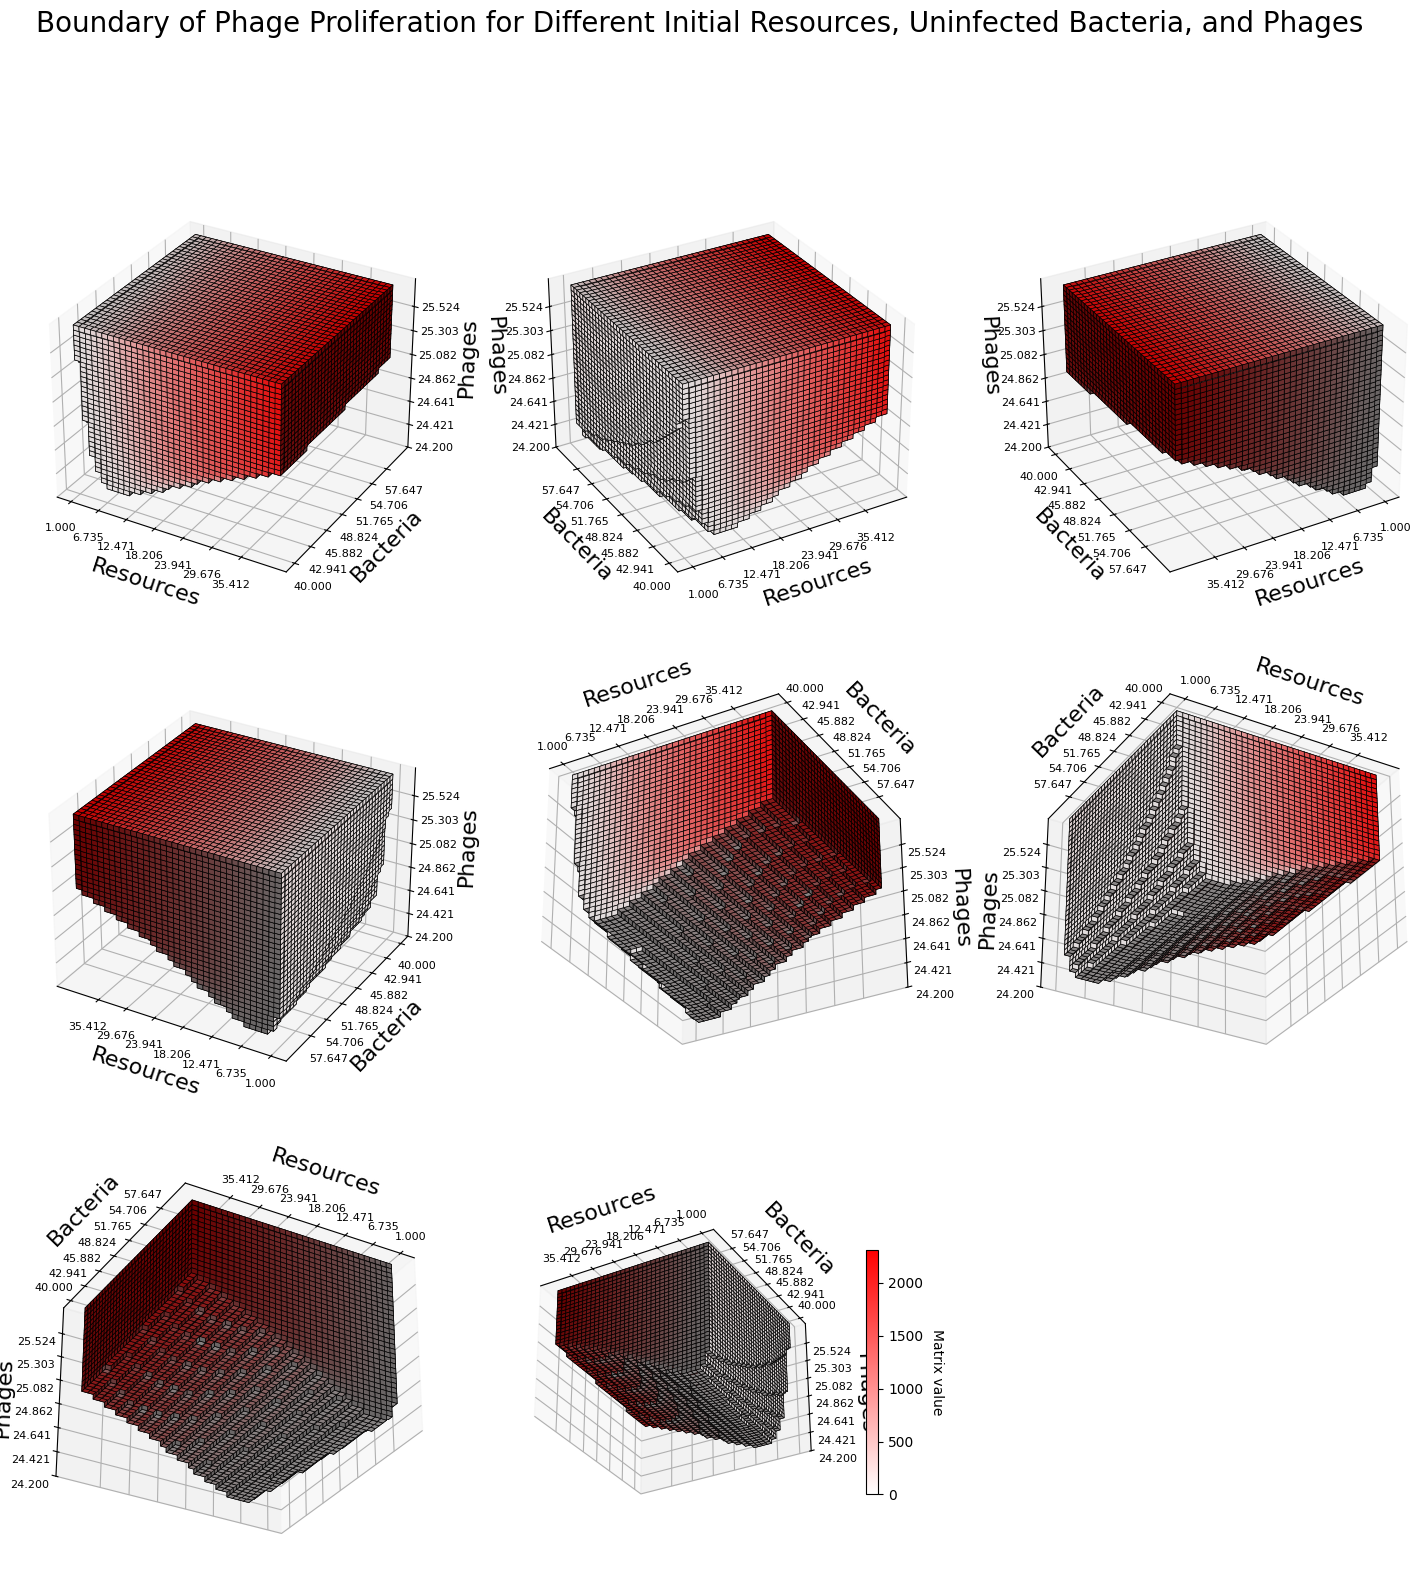

In [68]:
with open(pickle_file_path, 'rb') as f:
    pickle_data = pickle.load(f)
print("parameter_names_used", pickle_data['parameter_names_used'])
print("param_values_list_combination", pickle_data['param_values_list_combination'])
print('partition_data', pickle_data['agent_type_count'])
print("agent_type", pickle_data['agent_type'])
print("agent_names", pickle_data['agent_names'])

# matrix, matrix2 = analyze_matrix(pickle_data)
create_plot(len(pickle_data['param_values_list_combination'][0]), len(pickle_data['param_values_list_combination'][1]), len(pickle_data['param_values_list_combination'][2]), matrix, pickle_data, save_fig='3d_plot_resource_bacteria_phage.png'
)
